In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

In [3]:
import numpy as np
import utils
import tempfile

from utils import mackey_glass, mk_mackey_glass_dataset

import tensorflow as tf
from temporal_basis_transformation_network.keras import TemporalBasisTrafo
from temporal_basis_transformation_network import Inverse

import dlop_ldn_function_bases as bases

In [ ]:
N_wnd0, N_wnd1, N_wnd2, N_wnd3 = N_wnds = (16, 8, 8, 4)
ds_train, ds_val, ds_test = mk_mackey_glass_dataset(N_wnds=N_wnds, verbose=True)
N_wnd = ds_train.element_spec[0].shape[1]
N_pred = ds_train.element_spec[1].shape[1]
rms = 0.223

In [6]:
N_units0 = 1
N_units1 = 10
N_units2 = 10
N_units3 = 10
q0, q1 = 16, 8
q0, q1, q2, q3 = 16, 8, 8, 4
basis = bases.mk_ldn_basis
#basis = lambda q, _: np.eye(q)
H0 = basis(q0, N_wnd0)
H1 = basis(q1, N_wnd1)
H2 = basis(q2, N_wnd2)
H3 = basis(q3, N_wnd3)
model = tf.keras.models.Sequential([
  tf.keras.layers.Reshape((N_wnd, 1)),                       # (N_wnd0 + N_wnd1 + N_wnd2 + N_wnd3, 1)
  TemporalBasisTrafo(H0, n_units=N_units0, pad=False),       # (N_wnd1 + N_wnd2 + N_wnd3, q * N_units0)

  tf.keras.layers.Dense(N_units1, activation='relu'),        # (N_wnd1 + N_wnd2 + N_wnd3, N_units1)
  TemporalBasisTrafo(H1, n_units=N_units1, pad=False),       # (N_wnd2 + N_wnd3, q * N_units1)

  tf.keras.layers.Dense(N_units2, activation='relu'),        # (N_wnd2 + N_wnd3, N_units2)
  TemporalBasisTrafo(H2, n_units=N_units2, pad=False),       # (N_wnd3, q * N_units2)

  tf.keras.layers.Dense(N_units3, activation='relu'),        # (N_wnd3, N_units3)
  TemporalBasisTrafo(H3, n_units=N_units3, pad=False),       # (1, q * N_units3)
    
  tf.keras.layers.Dense(N_pred, use_bias=False),             # (1, N_pred)
  tf.keras.layers.Reshape((N_pred,))                         # (N_pred)
])


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.mse,
)

In [8]:
model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_val,
)

Epoch 1/20
400/400 [==============================] - 4s 7ms/step - loss: 0.9007 - val_loss: 0.0274
Epoch 2/20
400/400 [==============================] - 3s 6ms/step - loss: 0.0213 - val_loss: 0.0093
Epoch 3/20
400/400 [==============================] - 3s 6ms/step - loss: 0.0076 - val_loss: 0.0043
Epoch 4/20
400/400 [==============================] - 3s 6ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 5/20
400/400 [==============================] - 3s 6ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 6/20
400/400 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 8.2700e-04
Epoch 7/20
400/400 [==============================] - 3s 6ms/step - loss: 7.8283e-04 - val_loss: 6.9653e-04
Epoch 8/20
400/400 [==============================] - 3s 6ms/step - loss: 5.9886e-04 - val_loss: 4.8670e-04
Epoch 9/20
400/400 [==============================] - 3s 6ms/step - loss: 4.6394e-04 - val_loss: 4.0454e-04
Epoch 10/20
400/400 [==============================] - 3s 6ms/step - los

In [9]:
np.sqrt(model.evaluate(ds_test)) / rms

100/100 [==============================] - 0s 3ms/step - loss: 2.2769e-04


0.06766558949010515

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 33, 1)             0         
_________________________________________________________________
temporal_basis_trafo (Tempor (None, 18, 16)            0         
_________________________________________________________________
dense (Dense)                (None, 18, 10)            170       
_________________________________________________________________
temporal_basis_trafo_1 (Temp (None, 11, 80)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 11, 10)            810       
_________________________________________________________________
temporal_basis_trafo_2 (Temp (None, 4, 80)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4, 10)             8

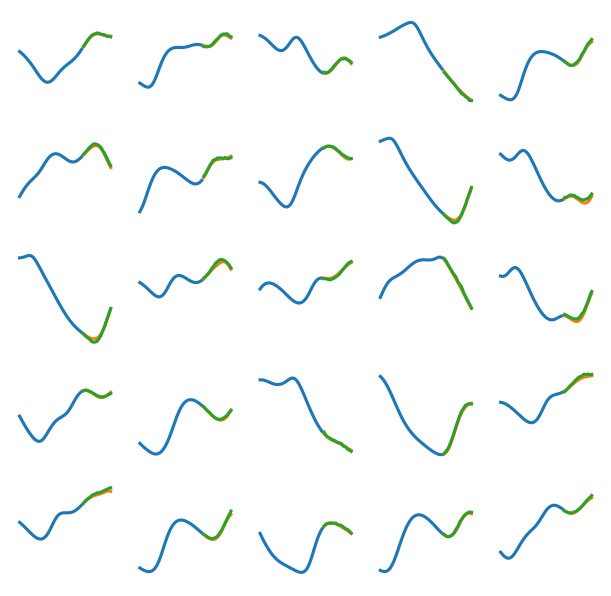

In [11]:
rows, cols = 5, 5
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(5.0, 5.0))
smpls_x = np.array([x[1][0] for x in zip(range(rows * cols), ds_test.unbatch().as_numpy_iterator())])
smpls_t = np.array([x[1][1] for x in zip(range(rows * cols), ds_test.unbatch().as_numpy_iterator())])
for i, ax in enumerate(axs.flat):
    ax.plot(np.arange(0, N_wnd), smpls_x[i])
    if N_pred > 10:
        ax.plot(np.arange(N_wnd, N_wnd + N_pred), smpls_t[i])
        ax.plot(np.arange(N_wnd, N_wnd + N_pred), model(smpls_x[i].reshape(1, -1)).numpy()[0])
    else:
        ax.scatter(np.arange(N_wnd, N_wnd + N_pred), smpls_t[i], marker='+')
        ax.scatter(np.arange(N_wnd, N_wnd + N_pred), model(smpls_x[i].reshape(1, -1)).numpy()[0], marker='+')
    for spine in ['left', 'bottom', 'top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])